Swimming Style Recognition Using a Smartwatch and Deep Learning

https://tik-old.ee.ethz.ch/file/0f8e59e6f86814ae7d7cb042effa8a5b/Swimming_paper_ISWC2019___camera_ready.pdf

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as Fun

# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print(device)

cuda


In [ ]:

if not os.path.exists("/content/SwimStyleRecog"):
  os.mkdir("/content/SwimStyleRecog")
os.chdir("/content/SwimStyleRecog")

! git clone https://github.com/brunnergino/swimming-recognition-lap-counting

Cloning into 'swimming-recognition-lap-counting'...
remote: Enumerating objects: 284, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 284 (delta 4), reused 13 (delta 3), pack-reused 269
Receiving objects: 100% (284/284), 405.51 MiB | 11.02 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Updating files: 100% (209/209), done.


Measurements are in 30 Hz, and we can use up to 6 sec sequences for analysis (up to 180 samples sequence as input). Every sample contains 9 features (3 Acc, 3 Gyro, 3 Magn) and label.
For output let's define 5 labels classes (remove labels -1 and 6, and rename label 5 to 0 (turn to transition)).

In [ ]:
import os
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

labels = {0: 'null', 1: 'freestyle', 2: 'breaststroke', 3: 'backstroke', 4: 'butterfly'} #, 5: 'turn'}
num_classes = len(labels)
# reshape data by n seconds (sample_len samples)
# I also tried 90,120,150,170,180 samples
sample_len = 170
input_channels_count = 9
train_ratio, validation_ratio, test_ratio=0.5, 0.25, 0.25

def separate_data(df, sample_len, train_ratio, validation_ratio, test_ratio):
  """
    separate data to train, validate, test dfs while load (for every file)
    sample_len is rows count
  """
  new_df_len = len(df) // sample_len * sample_len
  train_len = int((new_df_len * train_ratio) // sample_len * sample_len)
  validate_len = int((new_df_len * validation_ratio) // sample_len * sample_len)
  test_len = int((new_df_len * test_ratio) // sample_len * sample_len)

  df_train = df.iloc[:train_len, :]
  df_validate = df.iloc[train_len:train_len + validate_len, :]
  df_test = df.iloc[train_len + validate_len:train_len + validate_len + test_len, :]
  return df_train, df_validate, df_test

# clean data
def merge_df_list(df_list):
  df = pd.concat(df_list, ignore_index=True)
  # remove unnecessary columns
  df = pd.concat([df.iloc[:, 2:11], df.iloc[:, 13]], axis=1)
  # change all turn state to null (mean turn is transition)
  df['label'] = df['label'].replace(5, 0)
  return df.copy(deep=True)

def load_csv_files(directory):
    typed_dfs = {"Backstroke": [], "Breaststroke": [], "Butterfly": [],
                     "Freestyle": []}
    df_train_list, df_validate_list, df_test_list =[], [], []
    # load CSV files
    def recursive_load(directory):
      for root, dirs, files in os.walk(directory):
        for file in files:
          if file.endswith('.csv'):
            file_path = os.path.join(root, file)
            df = pd.read_csv(file_path)
            file_type = file_path.split("_")[-2].split("/")[-1]
            if file_type not in typed_dfs:
              print(f"{file_type=} not in file_types")
            else:
              # remove row with label value of -1 and 6
              df = df[~df['label'].isin([-1, 6])]
              df_train, df_val, df_test = separate_data(df, sample_len,train_ratio, validation_ratio, test_ratio)
              df_train_list.append(df_train)
              df_validate_list.append(df_val)
              df_test_list.append(df_test)

    recursive_load(directory)

    # Merge every DataFrames list into a single DataFrame
    return {
        "train" : merge_df_list(df_train_list),
        "validate" : merge_df_list(df_validate_list),
        "test" : merge_df_list(df_test_list)
        }

directory_path = "/content/SwimStyleRecog/swimming-recognition-lap-counting/data/processed_30hz_relabeled/"
merged_df_dict = load_csv_files(directory_path)

for data_type in merged_df_dict:
      print(f"{data_type} labels: {set(merged_df_dict[data_type]['label'])}")

train labels: {0.0, 1.0, 2.0, 3.0, 4.0}
validate labels: {0.0, 1.0, 2.0, 3.0, 4.0}
test labels: {0.0, 1.0, 2.0, 3.0, 4.0}


Check classes distribution for train, validate, test

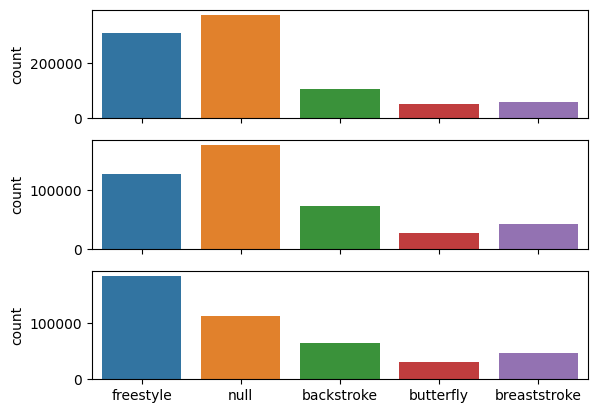

In [ ]:
fig, axes = plt.subplots(len(merged_df_dict), 1, sharex=True)

for i, df_key in enumerate(merged_df_dict):
  sns.countplot(ax=axes[i], x=[labels[lbl] for lbl in merged_df_dict[df_key]["label"]])

Save merged dataframes

In [ ]:
print(f"merged: train_len={len(merged_df_dict['train'])/sample_len}")
print(f"merged: validate_len={len(merged_df_dict['validate'])/sample_len}")
print(f"merged: test_len={len(merged_df_dict['test'])/sample_len}")
merged_df_dict['train'].to_pickle("./df_train.pkl")
merged_df_dict['validate'].to_pickle("./df_validate.pkl")
merged_df_dict['test'].to_pickle("./df_test.pkl")


merged: train_len=5314.0
merged: validate_len=2606.0
merged: test_len=2606.0


Let's read pickled dataframes and train the CNN.
It will take approximately 30 minutes to 95% accuracy on test dataset

In [ ]:
class CNNModel(nn.Module):
    # tests with batchnorm and dropout did not give better accuracy
    def __init__(self, in_ch, num_classes, do_batchnorm=1, do_dropout=False):
        super(CNNModel, self).__init__()
        nn_size = [59, 19, 5, 1]  # [160, 40, 10, 1] # [59, 22, 10, 5, 1]  #
        drop_prob = [0.3, 0.2, 0.2, 0.1, 0.1, 0.1]
        self.do_batchnorm = do_batchnorm
        self.do_dropout = do_dropout

        self.conv1 = nn.Conv1d(in_channels=in_ch, out_channels=nn_size[0], kernel_size=3, stride=1)
        self.elu1 = nn.ELU()
        self.max_pool1 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.drop1 = nn.Dropout(drop_prob[0])
        self.bn1 = nn.BatchNorm1d(nn_size[0])

        self.conv2 = nn.Conv1d(nn_size[0], nn_size[1], kernel_size=3, stride=1)
        self.elu2 = nn.ELU()
        self.max_pool2 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.drop2 = nn.Dropout(drop_prob[1])
        self.bn2 = nn.BatchNorm1d(nn_size[1])

        self.conv3 = nn.Conv1d(nn_size[1], nn_size[2], kernel_size=3, stride=1)
        self.elu3 = nn.ELU()
        self.max_pool3 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.drop3 = nn.Dropout(drop_prob[2])
        self.bn3 = nn.BatchNorm1d(nn_size[2])

        self.conv4 = nn.Conv1d(nn_size[2], nn_size[3], kernel_size=3, stride=1)
        self.elu4 = nn.ELU()
        self.max_pool4 = nn.MaxPool1d(kernel_size=3, stride=1)
        self.drop4 = nn.Dropout(drop_prob[3])
        self.bn4 = nn.BatchNorm1d(nn_size[3])

        if len(nn_size) == 5:
            self.conv5 = nn.Conv1d(nn_size[3], nn_size[4], kernel_size=3, stride=1)
            self.elu5 = nn.ELU()
            self.max_pool5 = nn.MaxPool1d(kernel_size=3, stride=1)
            self.drop5 = nn.Dropout(drop_prob[4])
            self.bn5 = nn.BatchNorm1d(nn_size[4])

        self.fc = nn.Linear(in_features=sample_len - len(nn_size) * 4, out_features=128)
        self.elu_fc = nn.ELU()
        self.drop_fc = nn.Dropout(drop_prob[5])

        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.elu1(x)
        x = self.max_pool1(x)
        if self.do_batchnorm:
            x = self.bn1(x)
        if self.do_dropout:
            x = self.drop1(x)

        x = self.conv2(x)
        x = self.elu2(x)
        x = self.max_pool2(x)
        if self.do_batchnorm:
            x = self.bn2(x)
        if self.do_dropout:
            x = self.drop2(x)

        x = self.conv3(x)
        x = self.elu3(x)
        x = self.max_pool3(x)
        if self.do_batchnorm:
            x = self.bn3(x)
        if self.do_dropout:
            x = self.drop3(x)

        x = self.conv4(x)
        x = self.elu4(x)
        x = self.max_pool4(x)
        if self.do_batchnorm:
            x = self.bn4(x)
        if self.do_dropout:
            x = self.drop4(x)

        # x = self.conv5(x)
        # x = self.elu5(x)
        # x = self.max_pool5(x)
        # if self.do_batchnorm:
        #     x = self.bn5(x)
        # if self.do_dropout:
        #     x = self.drop5(x)

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc(x)
        x = self.elu_fc(x)
        if self.do_dropout:
            x = self.drop_fc(x)

        x = self.fc2(x)
        x = self.softmax(x)
        return x


# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, data, augmentate=False, shuffle=False, rand_offset=False):
        self.data = data
        self.augmentate = augmentate
        # add manual shuffling, cause DataLoader shuffling have troubles with cuda
        self.shuffle = shuffle
        # add data shift
        self.rand_offset = rand_offset

    def __getitem__(self, index):
        if self.shuffle:
            index = int(torch.randint(0, self.data.shape[0], (1,)))
        inputs = torch.tensor(self.data[index][:, :], dtype=torch.float32)
        if self.rand_offset and index < self.data.shape[0] - 1:
            # get next sequence for data offset
            inputs_next = torch.tensor(self.data[index + 1][:, :], dtype=torch.float32)
            # add rand shift to next data sequence
            max_offset = inputs.shape[0]
            rand_offset = int(torch.randint(0, max_offset, (1,))) if max_offset > 0 else 0
            inputs = torch.cat((inputs[rand_offset:, :], inputs_next[:rand_offset, :]), 0)

        # need transpose for [BatchSize, Channels, Sequence] format
        inputs = inputs.transpose(0, 1).contiguous()

        # Most frequent value in the above array
        labels_tensor = inputs[-1, :]

        # Now we can remove labels from inputs
        inputs = inputs[:-1, :]

        # find most frequent label
        values, counts = torch.mode(labels_tensor)
        if len(values.shape) == 0:
            # values is 0-dim
            label = values.to(dtype=torch.long)
        else:
            most_freq_label = values[torch.argmax(counts)]
            freq = counts.max() / labels_tensor.shape[0]

            # if sequence contains few styles then label it as transition
            if freq > 0.75:  # len(set(labels_array)) == 1:
                label = most_freq_label.to(dtype=torch.long)
            else:
                label = torch.tensor(0, dtype=torch.long)

        if label != 0 and self.augmentate:
            # add a little augmentation
            # (scale from 50 to 150%)
            inputs = inputs * (0.5 + 1. * torch.rand(1))

            # and slowdown to (100+x)%
            inputs_3d = torch.zeros(1, inputs.size(0), inputs.size(1))
            inputs_3d[0] = inputs
            inputs_3d = Fun.interpolate(inputs_3d, scale_factor=1 + 0.5 * float(torch.rand(1)),
                                        mode="linear", align_corners=False, recompute_scale_factor=False)
            inputs = inputs_3d[0][:, :inputs.size(1)]

            # add noise
            inputs += torch.randn(inputs.size(0), inputs.size(1)) * 0.01

        return inputs, label

    def __len__(self):
        return len(self.data)


# Training Function
def train(model, optimizer, num_epochs, best_validation_accuracy=0.0, continue_while_accuracy_is_improving=False):
    best_accuracy = best_validation_accuracy

    print("Begin training...")
    epoch = 1
    prev_accuracy, accuracy = -1.0, 0.0

    while epoch < num_epochs + 1 or (continue_while_accuracy_is_improving and accuracy > prev_accuracy):
        running_train_loss = 0.0
        running_accuracy = 0.0
        running_val_loss = 0.0
        total = 0

        # Training Loop
        model.train()
        for inputs, outputs in train_loader:
            # forward + backward + optimize
            optimizer.zero_grad()  # zero the parameter gradients
            predicted_outputs = model(inputs)  # forward pass, predict output from the model
            train_loss = loss_fn(predicted_outputs, outputs)  # calculate loss for the predicted output
            train_loss.backward()  # backpropagate the loss
            optimizer.step()  # adjust parameters based on the calculated gradients
            running_train_loss += train_loss.item()  # track the loss value

        # Calculate training loss value
        train_loss_value = running_train_loss / len(train_loader)

        # Validation Loop
        with torch.no_grad():
            model.eval()
            for data in validate_loader:
                inputs, outputs = data
                predicted_outputs = model(inputs)
                val_loss = loss_fn(predicted_outputs, outputs)

                # The label with the highest value will be our prediction
                _, predicted = torch.max(predicted_outputs, 1)
                running_val_loss += val_loss.item()
                total += outputs.size(0)
                running_accuracy += (predicted == outputs).sum().item()

                # Calculate validation loss value
        val_loss_value = running_val_loss / len(validate_loader)

        prev_accuracy = accuracy
        # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.
        accuracy = (100 * running_accuracy / total)

        # Save the model if the accuracy is the best
        if accuracy > best_accuracy:
            torch.save(model.state_dict(), model_path)
            best_accuracy = accuracy
            print(f"Net model resaved with {accuracy=}")

            # Print the statistics of the epoch
        print('Completed training epoch', epoch, 'Training Loss is: %.4f' % train_loss_value,
              'Validation Loss is: %.4f' % val_loss_value, 'Accuracy is %d %%' % (accuracy))

        epoch += 1
    return best_accuracy


# Function to test the model
def test(model_path, loader, do_batchnorm):
    # Load the model that we saved at the end of the training loop
    model = CNNModel(input_channels_count, num_classes, do_batchnorm=do_batchnorm)
    model.load_state_dict(torch.load(model_path))

    running_accuracy = 0
    total = 0

    with torch.no_grad():
        model.eval()
        for data in loader:
            inputs, outputs = data
            outputs = outputs.to(torch.float32)
            predicted_outputs = model(inputs)
            _, predicted = torch.max(predicted_outputs, 1)
            total += outputs.size(0)
            running_accuracy += (predicted == outputs).sum().item()

        print('Accuracy of the model based on the test set inputs is: %d %%' % (100 * running_accuracy / total))
    return (100 * running_accuracy / (total if total != 0 else 1))
    # Optional: Function to test which species were easier to predict


# Set device
cuda = True
device = torch.device("cuda" if (
        torch.cuda.is_available() and cuda) else "cpu")
torch.set_default_tensor_type("torch.FloatTensor")
if device.type == "cuda":
    torch.set_default_tensor_type("torch.cuda.FloatTensor")
print(device)

# for first run
if (not os.path.exists("./df_train.pkl") or not os.path.exists("./df_test.pkl")
        or not os.path.exists("./df_validate.pkl")):
    load_data()

df_train = pd.read_pickle("./df_train.pkl")
df_validate = pd.read_pickle("./df_validate.pkl")
df_test = pd.read_pickle("./df_test.pkl")

# Load data into a pandas DataFrame (assuming it's named 'df')
# Prepare data by converting it into a format suitable for the custom dataset
train_data = df_train.values.reshape(-1, sample_len,
                                     input_channels_count + 1)  # Reshape to (num_samples, sequence_length, num_features)
validate_data = df_validate.values.reshape(-1, sample_len, input_channels_count + 1)
test_data = df_test.values.reshape(-1, sample_len, input_channels_count + 1)

# !set augmentation and offsetting using!
train_dataset = CustomDataset(train_data, augmentate=1, shuffle=1, rand_offset=1)
validate_dataset = CustomDataset(validate_data)
test_dataset = CustomDataset(test_data)

# Create data loaders
batch_size = 64  # 1024 #64  # 4096 #32
kwargs = {'num_workers': 8, 'pin_memory': True} if device == 'cuda' else {}
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, **kwargs)
validate_loader = DataLoader(validate_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


def set_seeds(seed):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.cuda.manual_seed_all(seed) # multi-GPU


# set seed for reproducibility
SEED = 42
set_seeds(seed=SEED)

# Define the loss function and optimizer
# remove softmax end layer and change NLLLoss to CrossEntropyLoss
loss_fn = nn.NLLLoss()  # nn.CrossEntropyLoss() #
optimizers = [optim.Adam, optim.SGD, optim.RMSprop]
budget_epochs_before_90_acc = [50, 30, 20]
budget_epochs_after_90_acc = [20, 50, 20]

best_validation_accuracy, best_using_bn = 0, 0
hyperepoch = 0

model_path = "NetModel.pth"

# seems like we can train to 95% accuracy on test dataset
# let's restart training with different optimizers
while best_validation_accuracy < 95:
    # Initialize the CNN model
    using_bn = not ((hyperepoch // len(optimizers)) % 2)
    model = CNNModel(input_channels_count, num_classes, do_batchnorm=using_bn)

    if os.path.exists(model_path):
        model.load_state_dict(torch.load(model_path))
        best_validation_accuracy = test(model_path, validate_loader, using_bn)
        print(f"Load model, {best_validation_accuracy=}")

    # select optimizer
    optim_index = hyperepoch % len(optimizers)
    selected_optimizer = optimizers[optim_index]
    print(f"{selected_optimizer=}")

    # decrease start lr to the end
    learning_rate = 0.001 * (1 - 0.01 * best_validation_accuracy)  # or simple 0.0005
    print(f"{learning_rate=}")
    optimizer = selected_optimizer(model.parameters(), lr=learning_rate)
    # Training loop
    model.to(device)

    num_epochs = (budget_epochs_before_90_acc[optim_index] if best_validation_accuracy < 90
                  else budget_epochs_after_90_acc[optim_index])
    best_validation_accuracy = train(model, optimizer, num_epochs,
                                     best_validation_accuracy=best_validation_accuracy,
                                     continue_while_accuracy_is_improving=True)
    print('Finished Training, check model on test dataset:')
    # test best saved model
    # todo: test with params like do_batchnorm (need to save do_batchnorm and other params with model)
    test(model_path, test_loader, using_bn)
    hyperepoch += 1

cuda
selected_optimizer=<class 'torch.optim.adam.Adam'>
learning_rate=0.001
Begin training...
Net model resaved with accuracy=54.451266308518804
Completed training epoch 1 Training Loss is: -0.4942 Validation Loss is: -0.5411 Accuracy is 54 %
Net model resaved with accuracy=56.52340752110514
Completed training epoch 2 Training Loss is: -0.6146 Validation Loss is: -0.5615 Accuracy is 56 %
Net model resaved with accuracy=57.09900230237913
Completed training epoch 3 Training Loss is: -0.6277 Validation Loss is: -0.5688 Accuracy is 57 %
Completed training epoch 4 Training Loss is: -0.6148 Validation Loss is: -0.5654 Accuracy is 56 %
Completed training epoch 5 Training Loss is: -0.6273 Validation Loss is: -0.5709 Accuracy is 56 %
Completed training epoch 6 Training Loss is: -0.6125 Validation Loss is: -0.5644 Accuracy is 56 %
Completed training epoch 7 Training Loss is: -0.6441 Validation Loss is: -0.5699 Accuracy is 56 %
Net model resaved with accuracy=57.521105141980044
Completed training

Let's do the confusion test on train, validation and test datasets

In [ ]:
from sklearn.metrics import confusion_matrix

# constant for classes
classes = labels.values()


def draw_confusion_mat(loader):
    y_pred = []
    y_true = []

    # Function to test the model
    def confusion_test(model_path, loader):
        # Load the model that we saved at the end of the training loop
        model = CNNModel(input_channels_count, num_classes)
        model.load_state_dict(torch.load(model_path))
        model.eval()

        running_accuracy = 0
        total = 0

        with torch.no_grad():
            for data in loader:
                inputs, outputs = data
                outputs = outputs.to(torch.float32)
                predicted_outputs = model(inputs)

                output = (torch.max(torch.exp(predicted_outputs), 1)[1]).data.cpu().numpy()
                y_pred.extend(output)  # Save Prediction

                output_labels = outputs.data.cpu().numpy()
                y_true.extend(output_labels)  # Save Truth

    confusion_test(model_path, loader)
    # Build confusion matrix

    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index=[i for i in classes],
                         columns=[i for i in classes])

    sns.heatmap(df_cm, annot=True)
    plt.show()
    # plt.savefig('output.png')


draw_confusion_mat(test_loader)
draw_confusion_mat(validate_loader)
draw_confusion_mat(train_loader)

NameError: ignored